# Feature Loss

This is the notebook for the feature loss training technique.

## Imports

In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F
from torchvision.models import vgg16_bn


## Data

In [5]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
  %cp "/content/drive/My Drive/autoencoder-training/model_layers.py" .
  %cp "/content/drive/My Drive/autoencoder-training/baseline_model.py" .
  %cp "/content/drive/My Drive/autoencoder-training/featureLoss_function.py" .
  import baseline_model
  import featureLoss_function
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"
  from resnet_autoencoder_training import baseline_model
  from resnet_autoencoder_training import featureLoss_function

Mounted at /content/drive
replace __MACOSX/data/._valid? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

#tfms = get_transforms(do_flip = True)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0, 
                      p_lighting=0.75)
src = (ImageImageList.from_folder(image_path).split_by_folder().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

## Model

### Loss Function

In [7]:
vgg_m = vgg16_bn(True).features.cuda().eval()

requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

base_loss = F.mse_loss

feat_loss = featureLoss_function.FeatureLoss(vgg_m, blocks[0:3], [30,20,10], base_loss)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


### Model and Learner

In [0]:
autoencoder = baseline_model.autoencoder()
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

## Training

In [9]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.597943,0.607201,0.016911,0.098366,01:55
1,0.363925,0.453618,0.009416,0.072532,01:56
2,0.294692,0.382237,0.006694,0.059713,01:55
3,0.257524,0.347009,0.005767,0.054683,01:54
4,0.243891,0.333985,0.005360,0.052390,01:53


In [0]:
learn.metrics = [mean_squared_error, mean_absolute_error, r2_score, explained_variance]

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,r2_score,explained_variance,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-08


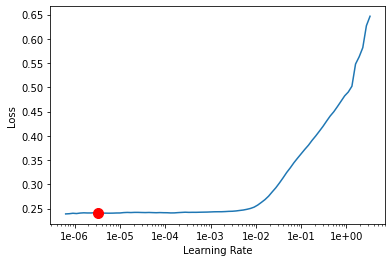

In [12]:
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(10, max_lr=1e-03)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,r2_score,explained_variance,time
0,0.242136,0.333882,0.005429,0.052995,0.911231,0.912364,01:53
1,0.242976,0.330734,0.005421,0.052942,0.911379,0.911789,01:52
2,0.237338,0.330736,0.006548,0.060230,0.893129,0.905937,01:52
3,0.228986,0.322008,0.008059,0.070101,0.866911,0.908820,01:52
4,0.222176,0.310765,0.005186,0.051970,0.915162,0.915829,01:52
5,0.214915,0.303640,0.005215,0.052599,0.914879,0.917444,01:55
6,0.208275,0.298651,0.006049,0.058746,0.900353,0.918983,01:53
7,0.202955,0.290449,0.004764,0.049863,0.921885,0.924654,01:53
8,0.199293,0.282545,0.004341,0.046690,0.929007,0.929338,01:53
9,0.197665,0.281357,0.004390,0.047108,0.928140,0.929410,01:53


## Results

### Training

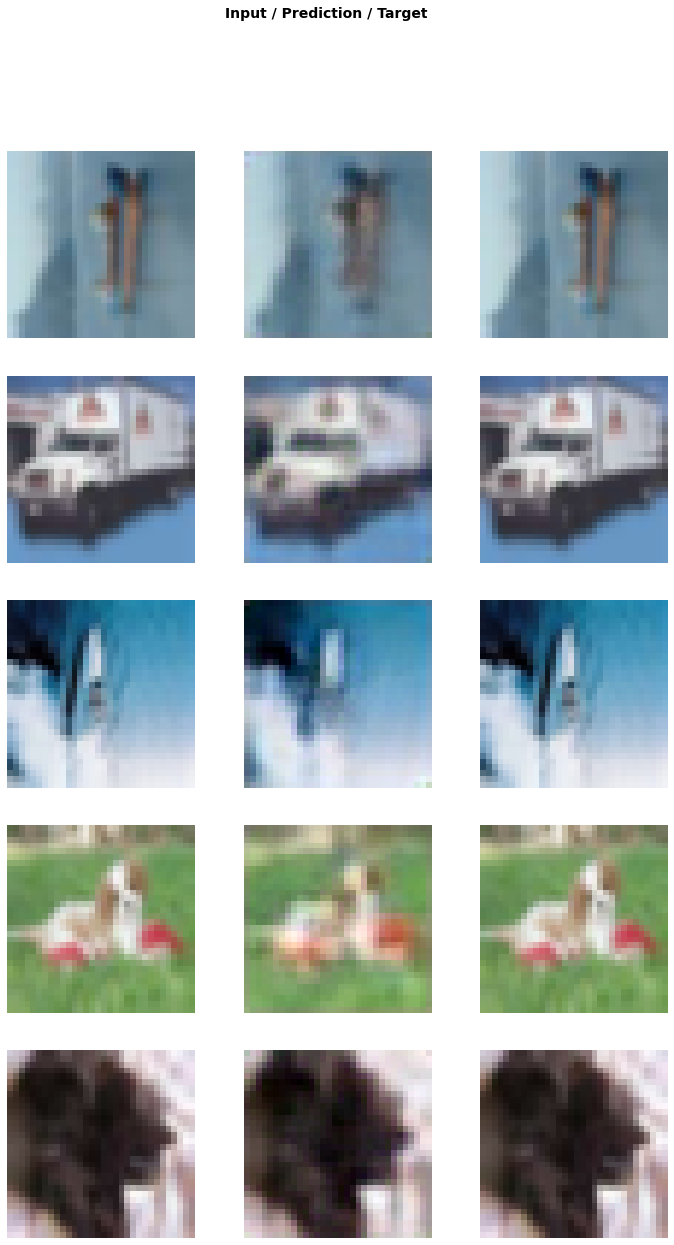

In [14]:
learn.show_results(ds_type=DatasetType.Train)

### Validation

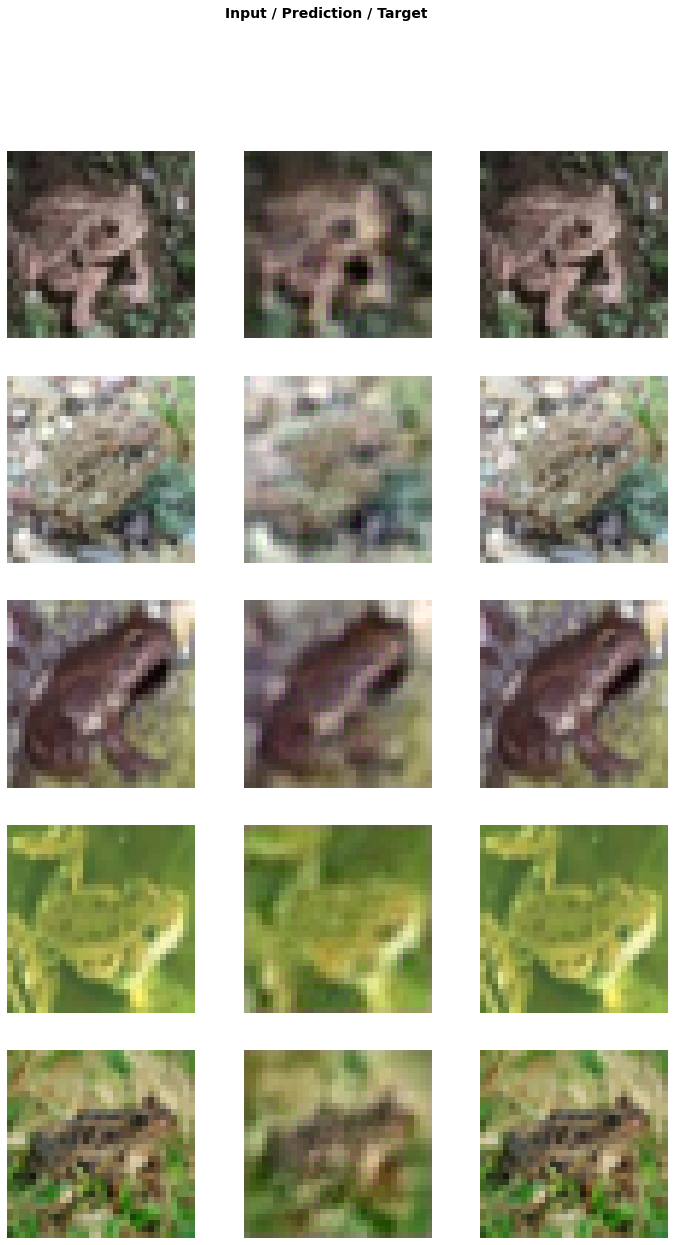

In [15]:
learn.show_results(ds_type=DatasetType.Valid)

## Final optimisation (not included in results)

Change back to MSE loss function to do final few epochs to optimise images. As can be seen below when just optimsiing the MSE the image start to become more blurred. This is due to the first few layers in the VGG being edge and shape detectors meaning the recreated images more represent the input's shape.

In [0]:
learn.loss_func = F.mse_loss

In [17]:
learn.fit_one_cycle(5, max_lr = 1e-06)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,r2_score,explained_variance,time
0,0.003282,0.004423,0.004423,0.047435,0.927556,0.930030,01:50
1,0.003006,0.004281,0.004281,0.046449,0.929991,0.930530,01:49
2,0.002977,0.004251,0.004251,0.046346,0.930473,0.931975,01:48
3,0.002948,0.004181,0.004181,0.045825,0.931636,0.932496,01:51
4,0.002963,0.004201,0.004201,0.045960,0.931293,0.932508,01:50


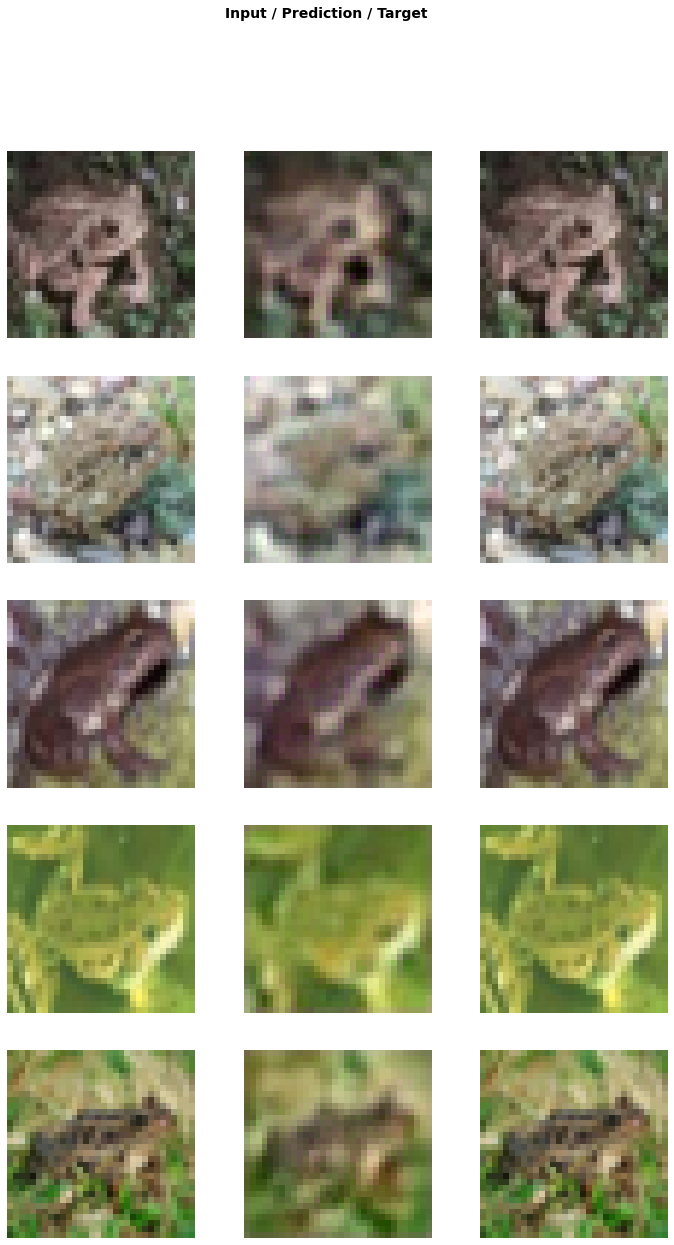

In [18]:
learn.show_results(ds_type=DatasetType.Valid)